In [1]:
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from networkx.algorithms import community
from uoineuro.coupling_utils import *
from uoineuro.utils import tighten_scatter_plot

%matplotlib inline

In [2]:
base_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling')

In [3]:
# consolidate AC results
ac_results_path = os.path.join(base_path, 'ecog/ecog_coupling.h5')
ac_results = h5py.File(ac_results_path, 'r')
ac_lasso_ccs = np.median(ac_results['lasso/coupling_coefs'], axis=0)
ac_uoi_lasso_ccs = np.median(ac_results['uoi_lasso_bic/coupling_coefs'], axis=0)

In [4]:
# consolidate VC results
vc_results_paths = [os.path.join(base_path, 'pvc11/pvc11_monkey1_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey2_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey3_coupling.h5')]
n_vc_fits = len(vc_results_paths)
vc_results = [h5py.File(vc_results_path, 'r')
              for vc_results_path in vc_results_paths]
# extract coupling coefficients
vc_lasso_ccs = [np.median(vc_result['lasso/coupling_coefs'], axis=0)
                for vc_result in vc_results]
vc_uoi_lasso_ccs = [np.median(vc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
              for vc_result in vc_results]
vc_glmnet_ccs = [np.median(vc_result['glmnet_poisson/coupling_coefs'], axis=0)
                for vc_result in vc_results]
vc_uoi_poisson_ccs = [np.median(vc_result['uoi_poisson_bic/coupling_coefs'], axis=0)
              for vc_result in vc_results]

In [5]:
# consolidate MC results
mc_results_paths = [os.path.join(base_path, 'nhp/nhp_indy_20160407_02_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_01_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_02_coupling.h5')]
n_mc_fits = len(mc_results_paths)
mc_results = [h5py.File(mc_results_path, 'r')
              for mc_results_path in mc_results_paths]
# extract coupling coefficients
mc_lasso_ccs = [np.median(mc_result['lasso/coupling_coefs'], axis=0)
                for mc_result in mc_results]
mc_uoi_lasso_ccs = [np.median(mc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
              for mc_result in mc_results]
mc_glmnet_ccs = [np.median(mc_result['glmnet_poisson/coupling_coefs'], axis=0)
                for mc_result in mc_results]
mc_uoi_poisson_ccs = [np.median(mc_result['uoi_poisson_bic/coupling_coefs'], axis=0)
              for mc_result in mc_results]

In [6]:
lasso_ccs = [ac_lasso_ccs] + vc_lasso_ccs + mc_lasso_ccs
uoi_lasso_ccs = [ac_uoi_lasso_ccs] + vc_uoi_lasso_ccs + mc_uoi_lasso_ccs
glmnet_ccs = vc_glmnet_ccs + mc_glmnet_ccs
uoi_poisson_ccs = vc_uoi_poisson_ccs + mc_uoi_poisson_ccs

In [7]:
lasso_sgraphs = [create_symmetrized_graph(lasso_ccs[idx])[0]
                for idx in range(len(lasso_ccs))]
uoi_lasso_sgraphs = [create_symmetrized_graph(uoi_lasso_ccs[idx])[0]
                    for idx in range(len(uoi_lasso_ccs))]
glmnet_sgraphs = [create_symmetrized_graph(glmnet_ccs[idx])[0]
                 for idx in range(len(glmnet_ccs))]
uoi_poisson_sgraphs = [create_symmetrized_graph(uoi_poisson_ccs[idx])[0]
                      for idx in range(len(uoi_poisson_ccs))]

In [8]:
lasso_dgraphs = [create_directed_graph(lasso_ccs[idx], weighted=True)
                for idx in range(len(lasso_ccs))]
uoi_lasso_dgraphs = [create_directed_graph(uoi_lasso_ccs[idx], weighted=True)
                    for idx in range(len(uoi_lasso_ccs))]
glmnet_dgraphs = [create_directed_graph(glmnet_ccs[idx], weighted=True)
                 for idx in range(len(glmnet_ccs))]
uoi_poisson_dgraphs = [create_directed_graph(uoi_poisson_ccs[idx], weighted=True)
                      for idx in range(len(uoi_poisson_ccs))]

In [19]:
d_graphs = {
    'ac_lasso': lasso_dgraphs[0],
    'ac_uoi_lasso': uoi_lasso_dgraphs[0],
    'vc_monkey1_baseline': glmnet_dgraphs[0],
    'vc_monkey2_baseline': glmnet_dgraphs[1],
    'vc_monkey3_baseline': glmnet_dgraphs[2],
    'mc_monkey1_baseline': glmnet_dgraphs[3],
    'mc_monkey2_baseline': glmnet_dgraphs[4],
    'mc_monkey3_baseline': glmnet_dgraphs[5],
    'vc_monkey1_uoi': uoi_poisson_dgraphs[0],
    'vc_monkey2_uoi': uoi_poisson_dgraphs[1],
    'vc_monkey3_uoi': uoi_poisson_dgraphs[2],
    'mc_monkey1_uoi': uoi_poisson_dgraphs[3],
    'mc_monkey2_uoi': uoi_poisson_dgraphs[4],
    'mc_monkey3_uoi': uoi_poisson_dgraphs[5],
}

In [20]:
in_degree = {
    key: np.array(list(dict(val.in_degree()).values()))
    for key, val in d_graphs.items()
}
out_degree = {
    key: np.array(list(dict(val.out_degree()).values()))
    for key, val in d_graphs.items()
}
modularities = {
    key: compute_modularity(val)
    for key, val in d_graphs.items()
}

In [44]:
colors = ['#4986ae', '#ff800e', '#78b26d']

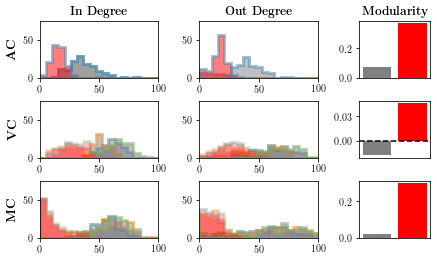

In [92]:
fig, axes = plt.subplots(3, 3, figsize=(7, 4),
                         gridspec_kw={'width_ratios': [1, 1, 0.6]})

bins = np.linspace(0, 100, 20)

axes[0, 0].hist(in_degree['ac_lasso'],
                alpha=0.75,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[0, 0].hist(in_degree['ac_uoi_lasso'],
                alpha=0.5,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[0, 1].hist(out_degree['ac_lasso'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[0, 1].hist(out_degree['ac_uoi_lasso'],
                alpha=0.5,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)

axes[1, 0].hist(in_degree['vc_monkey1_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[1, 0].hist(in_degree['vc_monkey1_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[1, 0].hist(in_degree['vc_monkey2_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[1, 0].hist(in_degree['vc_monkey2_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[1, 0].hist(in_degree['vc_monkey3_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)
axes[1, 0].hist(in_degree['vc_monkey3_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)

axes[1, 1].hist(out_degree['vc_monkey1_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[1, 1].hist(out_degree['vc_monkey1_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[1, 1].hist(out_degree['vc_monkey2_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[1, 1].hist(out_degree['vc_monkey2_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[1, 1].hist(out_degree['vc_monkey3_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)
axes[1, 1].hist(out_degree['vc_monkey3_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)

axes[2, 0].hist(in_degree['mc_monkey1_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[2, 0].hist(in_degree['mc_monkey1_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[2, 0].hist(in_degree['mc_monkey2_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[2, 0].hist(in_degree['mc_monkey2_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[2, 0].hist(in_degree['mc_monkey3_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)
axes[2, 0].hist(in_degree['mc_monkey3_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)

axes[2, 1].hist(out_degree['mc_monkey1_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[2, 1].hist(out_degree['mc_monkey1_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[0],
                linewidth=3)
axes[2, 1].hist(out_degree['mc_monkey2_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[2, 1].hist(out_degree['mc_monkey2_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[1],
                linewidth=3)
axes[2, 1].hist(out_degree['mc_monkey3_baseline'],
                alpha=0.5,
                color='gray',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)
axes[2, 1].hist(out_degree['mc_monkey3_uoi'],
                alpha=0.25,
                color='red',
                bins=bins,
                histtype='stepfilled',
                edgecolor=colors[2],
                linewidth=3)
for ax in axes[:, :2].ravel():
    ax.tick_params(labelsize=10)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 75])
    
axes[0, 2].bar(x=[0, 1],
               height=[modularities['ac_lasso'], modularities['ac_uoi_lasso']],
               color=['gray', 'red'])
axes[1, 2].bar(x=[0, 1],
               height=[np.mean([modularities['vc_monkey1_baseline'],
                                modularities['vc_monkey2_baseline'],
                                modularities['vc_monkey3_baseline']]),
                       np.mean([modularities['vc_monkey1_uoi'],
                                modularities['vc_monkey2_uoi'],
                                modularities['vc_monkey3_uoi']])],
               color=['gray', 'red'])
axes[2, 2].bar(x=[0, 1],
               height=[np.mean([modularities['mc_monkey1_baseline'],
                                modularities['mc_monkey2_baseline'],
                                modularities['mc_monkey3_baseline']]),
                       np.mean([modularities['mc_monkey1_uoi'],
                                modularities['mc_monkey2_uoi'],
                                modularities['mc_monkey3_uoi']])],
               color=['gray', 'red'])

axes[1, 2].axhline(0, color='k', linestyle='--')
axes[1, 2].set_yticks([0, 0.03])
for ax in axes[:, 2]:
    ax.set_xlim([-0.5, 1.5])
    ax.tick_params(labelsize=10)
    ax.set_xticks([])

axes[0, 0].set_title(r'\textbf{In Degree}', fontsize=12)
axes[0, 1].set_title(r'\textbf{Out Degree}', fontsize=12)
axes[0, 2].set_title(r'\textbf{Modularity}', fontsize=12)
axes[0, 0].set_ylabel(r'\textbf{AC}', fontsize=13)
axes[1, 0].set_ylabel(r'\textbf{VC}', fontsize=13)
axes[2, 0].set_ylabel(r'\textbf{MC}', fontsize=13)

plt.subplots_adjust(hspace=0.4, wspace=0.4)